#### Case 1: Isobaric evaporation of liquid hydrogen in a 4.89 $m^3$ spherical tank experiments.

This notebook sets up the isobaric evaporation of liquid hydrogen ($LH_2$) in a 4.89 $m^3$ storage tank. A high liquid filling, high heat ingress scenario from Hasan (1991) is considered. This tank is representative of lab-scale tanks used for cryogen evaporation experiments that measure boil-off rates and thermal stratification.

In [37]:
# Ensure that python finds the submodules
import sys
sys.path.append("..") # Adds higher directory to python modules path.

# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

## Module imports
# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

from scipy.integrate import simps

#### Setup tank and cryogen properties

In [38]:
# LNG tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 2.106 # Internal diameter / m
d_o = 2.106+2.08e-3   # External diameter / m
T_air = 350 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 0.01063 # W/m2/K
U_V = 0.01063 # W/m2/K

# Specify heat transfer rate at the bottom to prevent ground heating
Q_b = 0 # W, 

# Spherical tank volume
V_tank = 4.89 #m^3

# Initial liquid filling / Dimensionless
LF = 0.95

# Specify tank operating pressure
P = 117e3 # Pa

Geo_v1 = "spherical"

Geo_l1 = "spherical"

# Initialize large-scale tank
small_tank1 = Tank(d_i, d_o, V_tank, Geo_v1, Geo_l1,LF)
small_tank1.set_HeatTransProps(U_L, U_V, T_air, Q_roof, Q_b, eta_w = 0.95)

# Initialise cryogen
hydrogen1 = Cryogen(name = "hydrogen")
hydrogen1.set_coolprops(P)


# Set cryogen
small_tank1.cryogen = hydrogen1

# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen1.name + " is %.1e kg/h" % (small_tank1.b_l_dot * 3600))

The initial evaporation rate of hydrogen is 3.9e-01 kg/h


Calculate initial evaporation rate and transient period

In [39]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen1.name + " is %.1e kg/h" % (small_tank1.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % small_tank1.tau)

# Minimum number of hours to achieve steady state 
tau_h1 = (np.floor(small_tank1.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h1 )

# Calculate boil-off rate
BOR1 = (small_tank1.b_l_dot * 24 * 3600) / (small_tank1.V * small_tank1.LF * small_tank1.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR1 * 100))

The initial evaporation rate of hydrogen is 3.9e-01 kg/h
Transient period = 6505.059 s 
Simulation time: 2 h
BOR = 2.877 %


#### Simulation setup and execution

In [40]:
# Define vertical spacing
dz = 0.005*2

# Calculate number of nodes
n_z = 1 + int(np.round(small_tank1.l_V/dz, 0))

# Define dimensionless computational grid
small_tank1.z_grid = np.linspace(0, 1, n_z)

# Insulated roof
small_tank1.U_roof = 0

# Define evaporation time as twice as the transient period
#evap_time = 3600 *tau_h1*4
evap_time = 3600*40

# Time step to record data, relevant for plotting integrated quantities
# such as the vapour to liquid heat transfer rate, Q_VL
small_tank1.time_interval = 60

# Time step to plot each vapour temperature profile
small_tank1.plot_interval = evap_time/6

# Simulate the evaporation
small_tank1.evaporate(evap_time)

/home/aeb23/IRP/CryoEvap/notebooks/../cryoevap/storage_tanks/tank.py:473: RuntimeWarning: divide by zero encountered in divide
  vz = self.v_z*(l_L[i]/zed)*(2*self.d_i/2 - l_L[i])/(2*self.d_i/2 - zed)


#### Visualisation of results

#### Vapour temperature

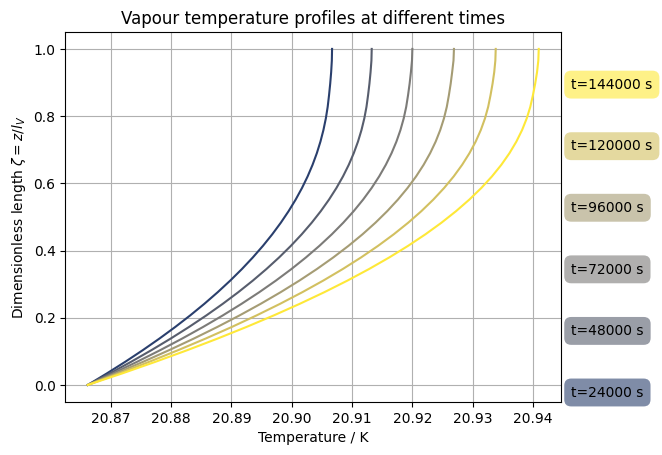

In [41]:
# Visualise the plot
small_tank1.plot_tv()

In [42]:
# small_tank1.plot_A_T()
# small_tank1.plot_l_L()
# small_tank1.plot_LF()
# small_tank1.plot_rho_V_avg()

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

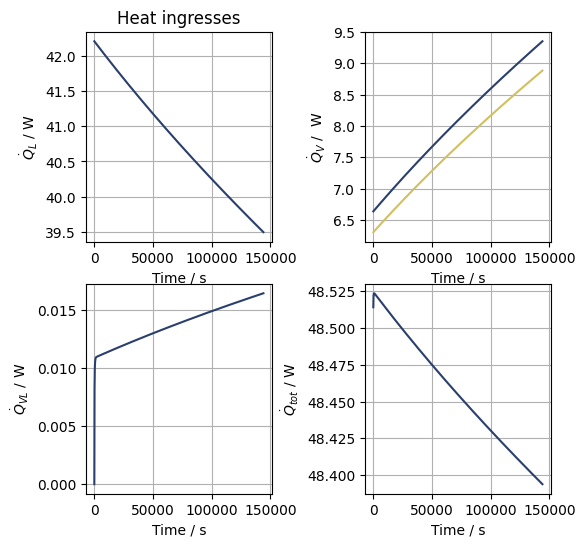

In [43]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_Q(unit="W")

#### Plot liquid volume

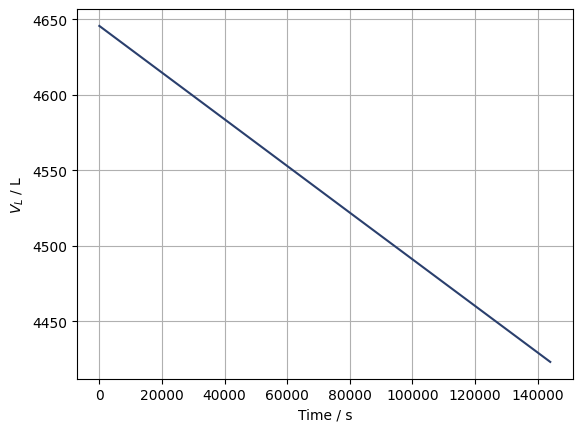

In [44]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_V_L(unit="L")

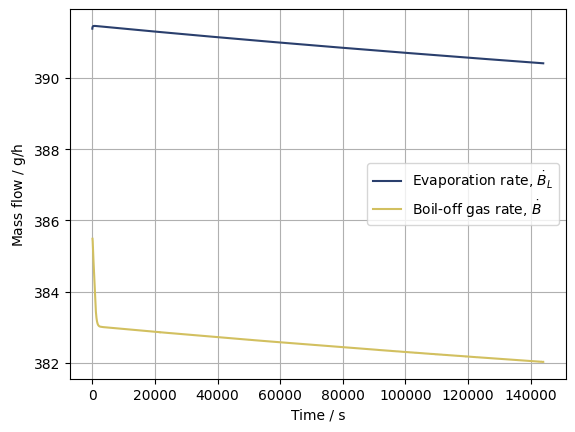

In [45]:
# Provide optional parameter unit to
# accommodate the scale of the experiment
small_tank1.plot_BOG(unit='g/h')

/home/aeb23/IRP/CryoEvap/notebooks/../cryoevap/storage_tanks/plots.py:253: RuntimeWarning: divide by zero encountered in divide
  v_z = tank.v_z*(height/zed)*(2*tank.d_i/2 - height)/(2*tank.d_i/2 - zed)


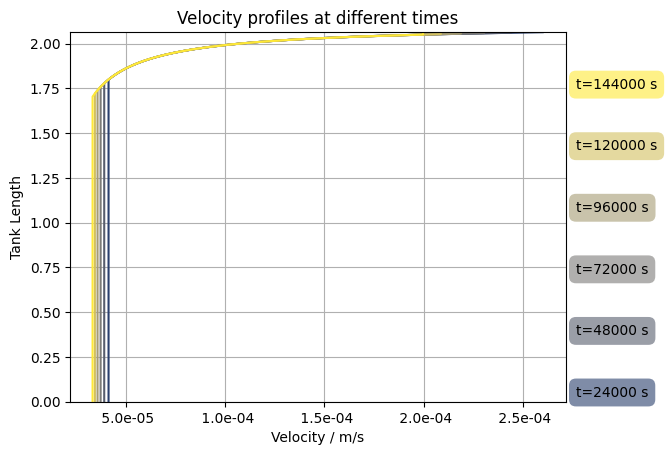

In [46]:
small_tank1.plot_vz()

In [47]:
print(len(small_tank1.data["BOG"]))

2401


In [48]:
small_tank1.data["Pressure"] = np.ones_like(small_tank1.data["B_L"])*P
air = P*(V_tank*(1-LF))/(8.314*hydrogen1.T_sat)
for i in range(1,len(small_tank1.data["B_L"])):
    small_tank1.data["Pressure"][i] = ((simps(small_tank1.data["B_L"][:i])*(1000/2) +air)*8.314*small_tank1.data["Tv_avg"][i])/(V_tank - small_tank1.data["V_L"][i])

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [49]:
# Import pandas 
import pandas as pd

In [50]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(small_tank1.data)

# Save file to the current working directory
df_evap.to_csv('LN2_small_m3.csv')

# Show the first five columns of the dataframe in console
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,z,A_T,vz_avg,vz,LF,dTV_avg,Q_Vw,Pressure
2396,143760,20.912450,1.512836,0.016459,39.498744,9.346033,4.423365,0.000108,0.000106,-1.812852e-08,-0.000002,1.703631,2.153525,0.000059,0.000033,0.904574,1.890862e-07,8.878731,109889.442246
2397,143820,20.912461,1.512835,0.016461,39.497747,9.347029,4.423273,0.000108,0.000106,-1.703770e-08,-0.000002,1.703588,2.153701,0.000059,0.000033,0.904555,1.776788e-07,8.879677,109887.898204
2398,143880,20.912471,1.512834,0.016463,39.496751,9.348025,4.423180,0.000108,0.000106,-1.716872e-08,-0.000002,1.703545,2.153877,0.000059,0.000033,0.904536,1.790494e-07,8.880623,109886.351939
2399,143940,20.912482,1.512833,0.016465,39.495755,9.349020,4.423087,0.000108,0.000106,-1.797197e-08,-0.000002,1.703502,2.154052,0.000059,0.000033,0.904517,1.874502e-07,8.881569,109884.810030
2400,144000,20.912494,1.512832,0.016467,39.494759,9.350016,4.422995,0.000108,0.000106,-1.844986e-08,-0.000002,1.703459,2.154228,0.000059,0.000033,0.904498,1.924483e-07,8.882515,109883.270331


In [51]:
df_evap['flux_v'] = df_evap["Q_V"]/(np.pi*d_i*(d_i-df_evap['z']))
df_evap['flux_l'] = df_evap["Q_L"]/(np.pi*d_i*(df_evap['z']))
df_evap['total_flux'] = (df_evap['Q_L']+df_evap['Q_V'])/(np.pi*d_i**2)
df_evap.head()
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,...,A_T,vz_avg,vz,LF,dTV_avg,Q_Vw,Pressure,flux_v,flux_l,total_flux
2396,143760,20.912450,1.512836,0.016459,39.498744,9.346033,4.423365,0.000108,0.000106,-1.812852e-08,...,2.153525,0.000059,0.000033,0.904574,1.890862e-07,8.878731,109889.442246,3.510706,3.504286,3.505513
2397,143820,20.912461,1.512835,0.016461,39.497747,9.347029,4.423273,0.000108,0.000106,-1.703770e-08,...,2.153701,0.000059,0.000033,0.904555,1.776788e-07,8.879677,109887.898204,3.510705,3.504286,3.505512
2398,143880,20.912471,1.512834,0.016463,39.496751,9.348025,4.423180,0.000108,0.000106,-1.716872e-08,...,2.153877,0.000059,0.000033,0.904536,1.790494e-07,8.880623,109886.351939,3.510704,3.504286,3.505512
2399,143940,20.912482,1.512833,0.016465,39.495755,9.349020,4.423087,0.000108,0.000106,-1.797197e-08,...,2.154052,0.000059,0.000033,0.904517,1.874502e-07,8.881569,109884.810030,3.510703,3.504286,3.505512
2400,144000,20.912494,1.512832,0.016467,39.494759,9.350016,4.422995,0.000108,0.000106,-1.844986e-08,...,2.154228,0.000059,0.000033,0.904498,1.924483e-07,8.882515,109883.270331,3.510702,3.504286,3.505512


In [52]:
df_evap.head()

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,...,A_T,vz_avg,vz,LF,dTV_avg,Q_Vw,Pressure,flux_v,flux_l,total_flux
0,0,20.866191,1.517272,-7.029429e-15,42.207326,6.638764,4.645500,0.000109,0.000109,0.000000,...,1.632722,0.000074,0.000044,0.950000,0.000000,6.306826,117000.000000,3.514906,3.504149,3.505607
1,60,20.868167,1.517100,5.194745e-03,42.206009,6.640041,4.645407,0.000109,0.000107,-0.000003,...,1.632996,0.000074,0.000044,0.949981,0.000031,6.308039,116966.671553,3.514883,3.504149,3.505604
2,120,20.869941,1.516929,7.166618e-03,42.204692,6.641323,4.645314,0.000109,0.000107,-0.000003,...,1.633270,0.000074,0.000044,0.949962,0.000029,6.309256,116970.779610,3.514861,3.504149,3.505601
3,180,20.871590,1.516770,8.236851e-03,42.203375,6.642606,4.645222,0.000109,0.000107,-0.000003,...,1.633544,0.000073,0.000044,0.949943,0.000027,6.310476,116974.197613,3.514841,3.504149,3.505599
4,240,20.873138,1.516620,8.918182e-03,42.202058,6.643892,4.645129,0.000109,0.000107,-0.000002,...,1.633818,0.000073,0.000044,0.949924,0.000025,6.311697,116977.049424,3.514822,3.504149,3.505597


In [53]:
df_evap["SCHM BOG"] = ((df_evap["BOG"]*1000*3600/2)*(273+15)*8.314)/101325
df_evap[-5:]

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,...,vz_avg,vz,LF,dTV_avg,Q_Vw,Pressure,flux_v,flux_l,total_flux,SCHM BOG
2396,143760,20.912450,1.512836,0.016459,39.498744,9.346033,4.423365,0.000108,0.000106,-1.812852e-08,...,0.000059,0.000033,0.904574,1.890862e-07,8.878731,109889.442246,3.510706,3.504286,3.505513,4.513979
2397,143820,20.912461,1.512835,0.016461,39.497747,9.347029,4.423273,0.000108,0.000106,-1.703770e-08,...,0.000059,0.000033,0.904555,1.776788e-07,8.879677,109887.898204,3.510705,3.504286,3.505512,4.513953
2398,143880,20.912471,1.512834,0.016463,39.496751,9.348025,4.423180,0.000108,0.000106,-1.716872e-08,...,0.000059,0.000033,0.904536,1.790494e-07,8.880623,109886.351939,3.510704,3.504286,3.505512,4.513951
2399,143940,20.912482,1.512833,0.016465,39.495755,9.349020,4.423087,0.000108,0.000106,-1.797197e-08,...,0.000059,0.000033,0.904517,1.874502e-07,8.881569,109884.810030,3.510703,3.504286,3.505512,4.513962
2400,144000,20.912494,1.512832,0.016467,39.494759,9.350016,4.422995,0.000108,0.000106,-1.844986e-08,...,0.000059,0.000033,0.904498,1.924483e-07,8.882515,109883.270331,3.510702,3.504286,3.505512,4.513968


In [54]:
df_evap['vz_avg']

0       0.000074
1       0.000074
2       0.000074
3       0.000073
4       0.000073
          ...   
2396    0.000059
2397    0.000059
2398    0.000059
2399    0.000059
2400    0.000059
Name: vz_avg, Length: 2401, dtype: float64

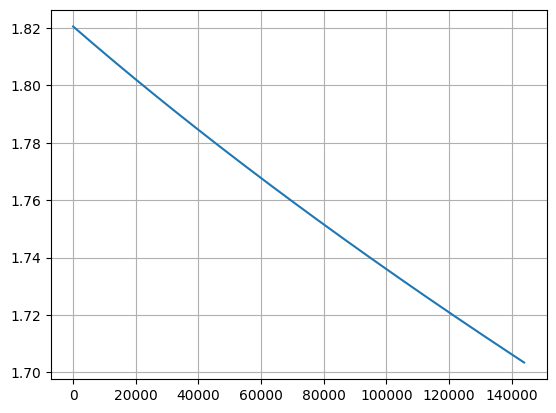

In [56]:
plt.plot(df_evap['Time'],df_evap['z'])
plt.grid(True)

#### References



Hasan, M., Lin, C. and Van Dresar, N. (1991). Self-Pressurization of a Flightweight Liquid Hydrogen Storage Tank Subjected to Low Heat Flux. [online] Available at: https://ntrs.nasa.gov/api/citations/19910011011/downloads/19910011011.pdf [Accessed 2 Jul. 2024].

Wang, Z. and Mérida, W. (2024). Thermal performance of cylindrical and spherical liquid hydrogen tanks. International Journal of Hydrogen Energy, 53, pp.667–683. doi:https://doi.org/10.1016/j.ijhydene.2023.11.287.